In [70]:
%pylab inline
import sys
import pandas as pd
import numpy as np
import datetime
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from yahoo_finance import Share
import pandas.io.data as web
import seaborn
import os, re

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_prices(symbol, start ='2014-05-02',  end = '2016-05-04' ):
    start, end = '2014-05-02', '2016-05-04'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    #prices=np.asarray(list(prices))
    prices=prices.astype(float)
    return prices

In [3]:
def get_xday_vol_ROLL(prices, x):
    vol = pd.rolling_apply((prices - prices.shift(x))/prices.shift(x), 500, np.std) * np.sqrt(252/x)
    #vol = np.std((pricesDF - pricesDF.shift(-x))/pricesDF) * np.sqrt(252/x)
    return vol

def get_vol_ratio_ROLL(prices, x, y):
    return get_xday_vol_ROLL(prices, x)/get_xday_vol_ROLL(prices, y)

In [35]:
def get_results2(prices):
    kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                    initial_state_mean=[prices[0],0],transition_covariance=[[.001,0],[0,.001]],
                    observation_covariance=1) #TC -> Q ;; OC -> R
    # kf=kf.em(prices,n_iter=5)
    (a,b)=kf.filter(prices)
    test_data = pd.DataFrame(prices)
    test_data.columns = ['prices']
    #test_data['signal'] = test_data
    test_data['filter'] = a[:,0]
    test_data['kal_vel'] = a[:,1]
    test_data['resids'] = test_data.prices - test_data['filter'] + test_data.kal_vel*0
    test_data['position'] = 0
    test_data['resid_dev'] = pd.rolling_apply(test_data.resids, 50,  np.std)                 # lookahead bias 
    test_data.loc[test_data.resids<-test_data.resid_dev, 'position'] = 1
    test_data.loc[test_data.resids>test_data.resid_dev, 'position'] = -1
    test_data['daily_diff'] = (test_data.prices.shift(-1) - test_data.prices)/test_data.prices
    test_data['results'] = test_data.position * test_data.daily_diff
    return test_data
    

In [43]:
def get_new_day(symbol):
    share = Share(symbol)
    share.refresh
    price_historical = get_prices(symbol)          # add dates
    price_today = share.get_price()
    
    today =  datetime.datetime.today().date()
    a = price_historical.index.tolist()
    a.append(pd.Timestamp(today))
    price_historical = price_historical.reindex(a)
    price_historical[today] = price_today

    dd = get_results2(price_historical)
    variance_ratio = get_vol_ratio_ROLL(price_historical, 1, 2)
    return dd.tail(1).position, variance_ratio

In [40]:
df = pd.read_pickle('../data/kal_returnsDF.pkl')
symbolsDF = pd.read_pickle('../data/symbolsDF.pkl')
sectors = symbolsDF.sector.unique().tolist()

In [85]:
posns = pd.DataFrame()
variance_ratios = pd.DataFrame()
for symbol in symbolsDF.index[1::50]:
    try:
        pos, varrat = get_new_day(symbol)
        posns[symbol] = pos
        variance_ratios[symbol] = varrat.tail(1)
    except:
        pass
posns * (variance_ratios>variance_ratios.mean(axis=1))

/Users/liamconnell/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


,CTL,AAPL,TXN,IP,WBA,LUK,BCR,ADT,ROK,HD,WYN
Date,,,,,,,,,,,
2016-05-07,0,0,0,1,0,0,0,0,0,0,0


In [86]:
trade = posns * (variance_ratios>variance_ratios.mean(axis=1))

/Users/liamconnell/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


In [87]:
trade_DF = '../data/trades/trade_DF.pkl'
if os.path.exists(trade_DF) == False:
    os.makedirs('../data/trades/')
    trade.to_pickle(trade_DF)
else:
    tradedf = pd.read_pickle(trade_DF)
    tradedf.append(trade).to_pickle(trade_DF)

In [88]:
tradedf

,CTL,AAPL,TXN,IP,WBA,LUK,BCR,ADT,ROK,HD,WYN
Date,,,,,,,,,,,
2016-05-04,0,0,1,1,-1,0,0,0,1,0,0
2016-05-05,0,0,1,1,0,0,0,0,1,0,0


In [90]:
pd.read_pickle(trade_DF)

,CTL,AAPL,TXN,IP,WBA,LUK,BCR,ADT,ROK,HD,WYN
Date,,,,,,,,,,,
2016-05-04,0,0,1,1,-1,0,0,0,1,0,0
2016-05-05,0,0,1,1,0,0,0,0,1,0,0
2016-05-07,0,0,0,1,0,0,0,0,0,0,0


In [89]:
trade

,CTL,AAPL,TXN,IP,WBA,LUK,BCR,ADT,ROK,HD,WYN
Date,,,,,,,,,,,
2016-05-07,0,0,0,1,0,0,0,0,0,0,0


In [83]:
tradedf = pd.read_pickle(trade_DF)

In [79]:
trade

,CTL,AAPL,TXN,IP,WBA,LUK,BCR,ADT,ROK,HD,WYN
Date,,,,,,,,,,,
2016-05-05,0,0,1,1,0,0,0,0,1,0,0


In [81]:
tradedf.append(trade)

,CTL,AAPL,TXN,IP,WBA,LUK,BCR,ADT,ROK,HD,WYN
Date,,,,,,,,,,,
2016-05-04,0,0,1,1,-1,0,0,0,1,0,0
2016-05-05,0,0,1,1,0,0,0,0,1,0,0


In [65]:
posns

,CTL,AAPL,TXN,IP,WBA,LUK,BCR,ADT,ROK,HD,WYN
Date,,,,,,,,,,,
2016-05-04,0,0,1,1,-1,1,0,0,1,0,0


In [84]:
tradedf

,CTL,AAPL,TXN,IP,WBA,LUK,BCR,ADT,ROK,HD,WYN
Date,,,,,,,,,,,
2016-05-04,0,0,1,1,-1,0,0,0,1,0,0
2016-05-05,0,0,1,1,0,0,0,0,1,0,0


In [58]:
posns * (variance_ratios>variance_ratios.mean(axis=1))

/Users/liamconnell/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


,T,TDC,WMT,AMGN,RHI,WHR
Date,,,,,,
2016-05-04,0,1,0,0,0,0


In [59]:
posns

,T,TDC,WMT,AMGN,RHI,WHR
Date,,,,,,
2016-05-04,0,1,1,1,0,0


In [62]:
(variance_ratios>variance_ratios.mean(axis=1))

/Users/liamconnell/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


,T,TDC,WMT,AMGN,RHI,WHR
Date,,,,,,
2016-05-04,False,True,False,False,False,True


In [41]:
def get_prices(symbol):
    start, end = '2013-05-02', '2016-05-04'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    #prices=np.asarray(list(prices))
    prices=prices.astype(float)
    return prices

In [42]:
gs_historical = get_prices('GS')

In [43]:
gs_historical.shape


(757,)

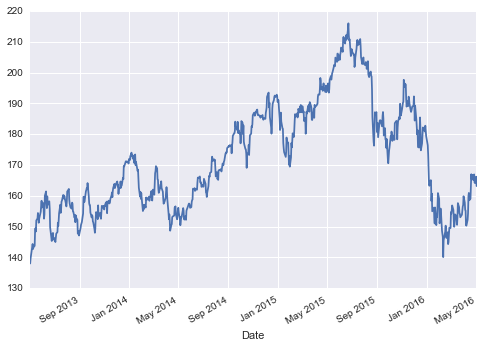

In [44]:
gs_historical.plot()

In [45]:
gs_historical.tail()

Date
2016-04-27    166.919998
2016-04-28    164.289993
2016-04-29    164.110001
2016-05-02    166.179993
2016-05-03    163.139999
Name: Adj Close, dtype: float64

In [48]:
def get_xday_vol_ROLL(prices, x):
    vol = pd.rolling_apply((prices - prices.shift(x))/prices, 500, np.std) * np.sqrt(252/x)
    #vol = np.std((pricesDF - pricesDF.shift(-x))/pricesDF) * np.sqrt(252/x)
    return vol

def get_vol_ratio_ROLL(prices, x, y):
    return get_xday_vol_ROLL(prices, x)/get_xday_vol_ROLL(prices, y)

In [ ]:
def get_results2(prices):
    kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                    initial_state_mean=[prices[0],0],transition_covariance=[[.001,0],[0,.001]],
                    observation_covariance=1) #TC -> Q ;; OC -> R
    # kf=kf.em(prices,n_iter=5)
    (a,b)=kf.filter(prices)
    test_data = pd.DataFrame(prices)
    test_data.columns = ['prices']
    test_data['signal'] = test_data
    test_data['filter'] = a[:,0]
    test_data['resids'] = test_data.prices - test_data['filter']
    test_data['position'] = 0
    test_data['resid_dev'] = pd.rolling_apply(test_data.resids, 50,  np.std)                 # lookahead bias 
    test_data.position[test_data.resids<-test_data.resid_dev] = 1
    test_data.position[test_data.resids>test_data.resid_dev] = -1
    test_data['daily_diff'] = (test_data.signal.shift(-1) - test_data.signal)/test_data.signal
    test_data['results'] = test_data.position * test_data.daily_diff
    return test_data
    

In [50]:
variance_ratio = get_vol_ratio_ROLL(gs_historical, 1, 4)

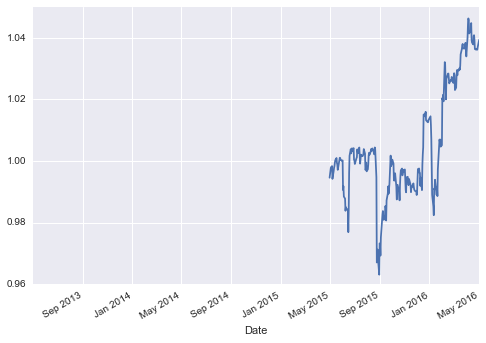

In [51]:
variance_ratio.plot()

In [63]:
def get_results2(prices):
    kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                    initial_state_mean=[prices[0],0],transition_covariance=[[.001,0],[0,.001]],
                    observation_covariance=1) #TC -> Q ;; OC -> R
    # kf=kf.em(prices,n_iter=5)
    (a,b)=kf.filter(prices)
    test_data = pd.DataFrame(prices)
    test_data.columns = ['prices']
    test_data['signal'] = test_data
    test_data['filter'] = a[:,0]
    test_data['resids'] = test_data.prices - test_data['filter']
    test_data['position'] = 0
    test_data['resid_dev'] = pd.rolling_apply(test_data.resids, 50,  np.std)                 # lookahead bias 
    test_data.position[test_data.resids<-test_data.resid_dev] = 1
    test_data.position[test_data.resids>test_data.resid_dev] = -1
    test_data['daily_diff'] = (test_data.signal.shift(-1) - test_data.signal)/test_data.signal
    test_data['results'] = test_data.position * test_data.daily_diff
    return test_data
    

In [65]:
dd = get_results2(gs_historical)

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


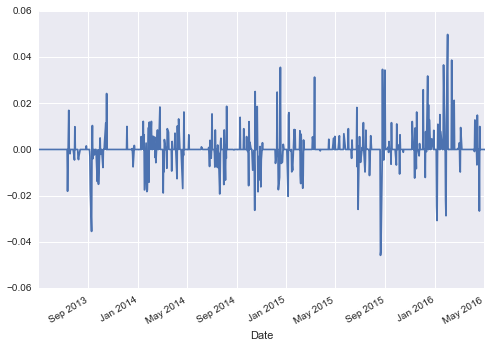

In [66]:
dd.results.plot()

In [68]:
get_vol_ratio_ROLL(gs_historical, 1, 2)[-1]

1.0065369858947295